In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

In [15]:
df = pd.read_csv("./output/input_data_hw.csv", index_col=[0], parse_dates=[0])
df = df.iloc[1 :]
df.head()

,dengue-sg-log,population-sg-log,temperature-sg-avg,temperature-sg-max,temperature-sg-min,temperature-sg-hot-days,temperature-sg-max-diff,temperature-sg-min-diff,rainfall-north-avg,rainfall-northeast-avg,...,rainfall-north-consecutive,rainfall-northeast-consecutive,rainfall-east-consecutive,rainfall-west-consecutive,rainfall-central-consecutive,rainfall-sg-consecutive,rel-humidity-avg,abs-humidity-avg,hw-season,hw-trend
human-times,,,,,,,,,,,,,,,,,,,,,
2000-01-15,2.397895,15.208752,26.000,27.025,24.650,0.0,-0.562084,-1.085547,7.900000,8.88,...,4.666667,4.2,3.75,5.571429,4.166667,4.56,86.074194,20.906830,-1.873670,1.369881
2000-01-22,2.772589,15.208752,25.975,26.825,24.850,0.0,-0.762084,-0.885547,20.066667,15.98,...,4.333333,2.4,1.75,4.285714,2.666667,3.12,86.435484,20.965371,-1.856535,0.789711
2000-01-29,2.772589,15.208752,25.875,26.775,24.650,0.0,-0.812084,-1.085547,2.600000,14.08,...,2.666667,3.2,4.25,3.142857,4.500000,3.60,86.796774,20.936021,-1.902900,0.832239
2000-02-05,2.639057,15.208752,25.800,26.800,25.000,0.0,-0.961159,-1.344137,4.266667,3.72,...,5.000000,4.4,4.00,4.285714,4.666667,4.44,86.831034,20.856882,-1.823253,1.008629
2000-02-12,2.995732,15.208752,26.400,26.675,25.925,0.0,-1.086159,-0.419137,15.266667,9.14,...,2.333333,3.6,2.25,3.142857,3.333333,3.04,86.734483,21.540984,-1.934925,0.639767


In [25]:
df["weekofyear"] = df.index.weekofyear
df["monthofyear"] = df.index.month

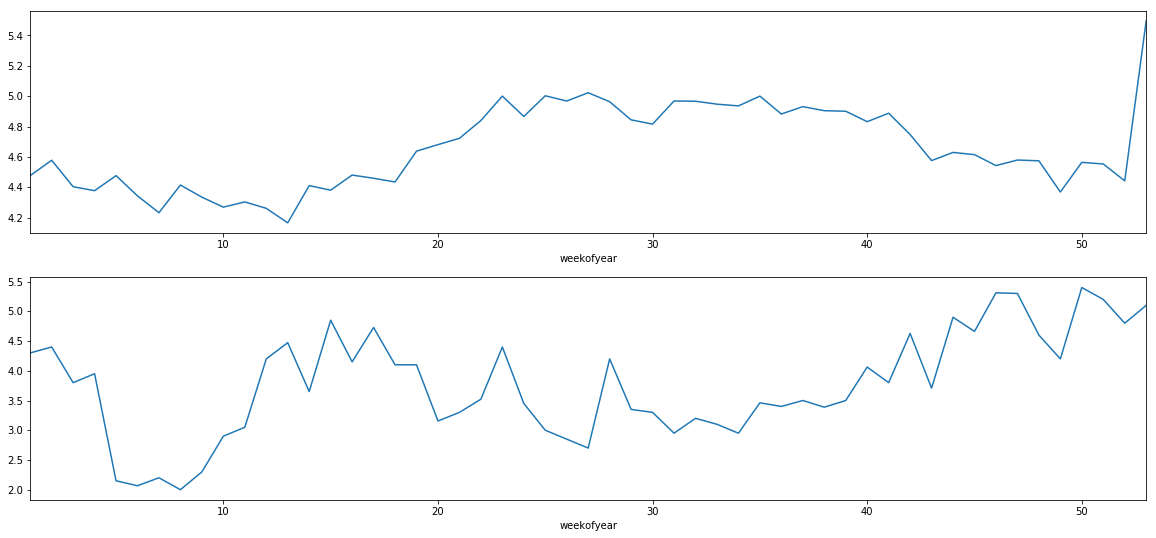

In [44]:
f, ax = plt.subplots(2, 1)
f.set_figheight(9)
f.set_figwidth(20)

df.groupby("weekofyear")["dengue-sg-log"].median().plot(ax=ax[0])
df.groupby("weekofyear")["rainfall-northeast-rainy-days"].median().plot(ax=ax[1])

# ax[0].plot(df.index, df["dengue-sg-log"], label="dengue")
# ax[1].plot(df.index, df["temperature-sg-min"], label="temperature-sg-min")
# df.groupby("weekofyear")["dengue-sg-log"].scatter(ax=ax[0])
# df.boxplot(column=["dengue-sg-log", "rainfall-sg-avg"], by="monthofyear", ax=ax[0])
# df.boxplot(column=["dengue-sg-log"], by="weekofyear", ax=ax[1])
# ax[0].scatter(df["weekofyear"], df["dengue-sg-log"], label="dengue-sg-log")
# ax[1].scatter(df["weekofyear"], df["temperature-sg-avg"], label="temperature-sg-avg")

# plt.legend(loc=7, bbox_to_anchor=(1.35, 0.5))
# plt.show()